In [318]:
import re
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import cluster, metrics, datasets

In [319]:
d = pd.read_csv("data/past_seasons_totals.csv", encoding="utf-8")

modern_data = d.loc[(d["Year"]>1980) & (d["G"]>27) & (d["MP"]>400)].fillna("0")
modern_data = modern_data.replace({"Pos": {"PG":"G", "SG":"G","PG-SG":"G","SG-PG":"G","SG-SF":"G","SF-SG":"F","SF":"F","SF-PF":"F","PF":"F","PF-SF":"F","SG-PF":"F","PG-SF":"F","C-PF":"C","PF-C":"C","C-SF":"C"}})
modern_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'formatname'],
      dtype='object')

In [320]:
X = modern_data[['3PAr', 'FTr', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%']]
y = modern_data["Pos"]

In [321]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [322]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 0.559803373007215


In [323]:
LDA = LinearDiscriminantAnalysis(n_components=2, solver='svd',store_covariance=True)
LDA_reduced_df = LDA.fit(X_scaled,y).transform(X_scaled)
LDA.score(X_scaled,y)

0.7867895805142084

best silhouette score: 0.41847487998981087


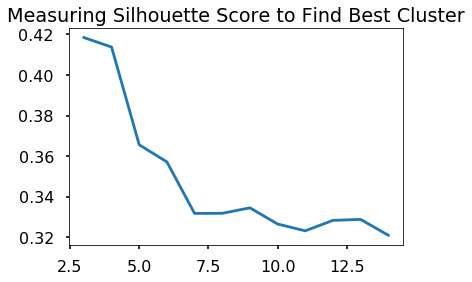

In [324]:
def kmeans(reduced_data, n_clusters):
    """
    performs kmeans clustering and returns labels, centroids, inertia, and silhouette score
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    kmeans = kmeans.fit(reduced_data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    inertia = kmeans.inertia_
    sil_score = metrics.silhouette_score(reduced_data, kmeans.labels_, metric='euclidean')

    data_dictionary = {
        "labels": labels,
        "centroids": centroids,
        "inertia" : inertia,
        "silhouette_score": sil_score
    }

    return data_dictionary

def find_best_cluster(data,a,b):
    """
    plots and finds the best silhouette score for range(a,b)
    """
    scores = []
    for i in range(a,b):
        i_clusters = kmeans(data, i)
        sil_score_i = i_clusters['silhouette_score']
        scores.append(sil_score_i)

    sns.set_context('poster', font_scale=1)
    plt.plot(range(a,b), scores)
    plt.title("""Measuring Silhouette Score to Find Best Cluster""")
    print("best silhouette score:", np.max(scores))
find_best_cluster(LDA_reduced_df,3,15)

In [325]:
kmeans = kmeans(LDA_reduced_df, 10)

In [326]:
modern_data['Cluster'] = kmeans['labels']
print("silhouette score:", kmeans['silhouette_score'])

silhouette score: 0.3266044924739558


In [327]:
y = kmeans['labels']
df = pd.DataFrame({'X1':LDA_reduced_df[:,0],'X2':LDA_reduced_df[:,1]})

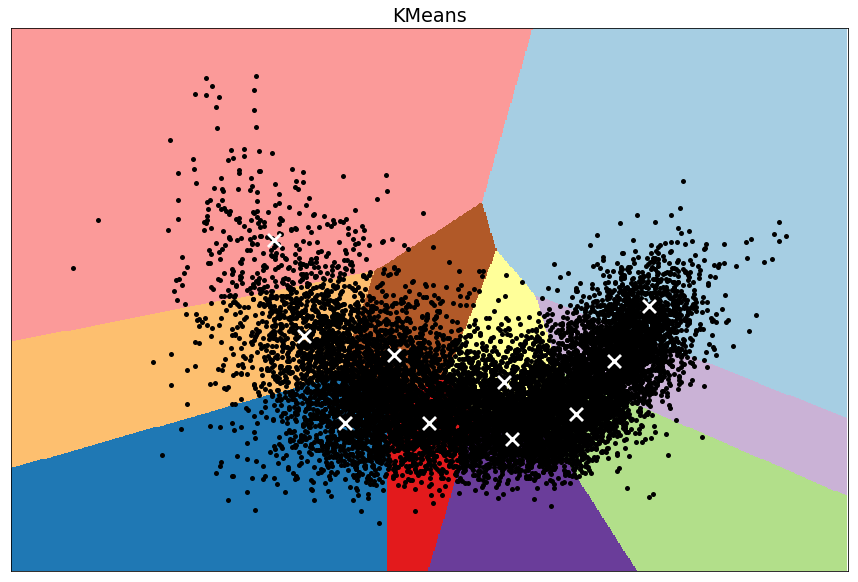

In [328]:
def plot_kmeans_cluster(reduced_data, k_clusters, plot_title):
    kmeans = KMeans(init='k-means++', n_clusters=k_clusters, n_init=3)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(15,10))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=10)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
    plt.title(plot_title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

plot_kmeans_cluster(LDA_reduced_df, k_clusters=10, plot_title="""KMeans""")

In [329]:
def feature_importance(cluster_data, league_data):
    """
    takes reduced data,
    performs Principal Component Analysis,
    returns feature importance dataframe
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)

    pca = PCA(n_components=2)
    PCA_reduced_df = pca.fit(scaled_data).transform(scaled_data)

    features = pd.DataFrame(zip(cluster_data.columns, pca.components_[0], np.mean(cluster_data), np.mean(league_data)),
        columns=['Feature', 'Importance', 'Cluster Average', 'League Average']).sort_values('Importance', ascending=False).head(10)

    return features

In [340]:
i = 0
mask = (modern_data['Cluster'] == i)

cluster_data = modern_data[mask][['3PAr', 'FTr', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%']]
league_data = modern_data[['3PAr', 'FTr', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

pca = PCA(n_components=3)
PCA_reduced_df = pca.fit(scaled_data).transform(scaled_data)

npmc = np.mean(cluster_data)
npml = np.mean(league_data)

features = pd.DataFrame(list(zip(cluster_data.columns, pca.components_[0], npmc, npml)), columns=['Feature', 'Importance', 'Cluster Average', 'League Average']).sort_values('Importance', ascending=False)#.head(10)
features

,Feature,Importance,Cluster Average,League Average
3,AST%,0.435021,14.173304,14.027427
2,TRB%,0.434090,6.188988,9.982722
4,STL%,0.383776,1.927976,1.664065
1,FTr,0.378949,0.247975,0.309351
7,USG%,0.332589,20.529310,19.094435
6,TOV%,0.262404,11.860679,14.198977
5,BLK%,0.180085,0.606785,1.493674
0,3PAr,-0.345738,0.301842,0.166235


In [341]:
modern_data.to_csv("test.csv")

In [342]:
modern_data.loc[(modern_data["Cluster"]==i) & (modern_data["Year"] > 1999)]

,Unnamed: 0,Unnamed: 0.1,Year,Player,Pos,Age,Tm,G,MP,PER,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,formatname,Cluster
12051,14475,14475,2000.0,Ray Allen,G,24.0,MIL,82.0,3070.0,20.6,...,276.0,359.0,308.0,110.0,19.0,183.0,187.0,1809.0,RayAllen,0
12054,14478,14478,2000.0,Derek Anderson,G,25.0,LAC,64.0,2201.0,16.9,...,178.0,258.0,220.0,90.0,11.0,167.0,149.0,1080.0,DerekAnderson,0
12071,14495,14495,2000.0,Brent Barry,G,28.0,SEA,80.0,2726.0,14.6,...,322.0,372.0,291.0,103.0,31.0,142.0,228.0,945.0,BrentBarry,0
12073,14499,14499,2000.0,Jon Barry,G,30.0,SAC,62.0,1281.0,15.9,...,121.0,159.0,150.0,75.0,7.0,85.0,104.0,495.0,JonBarry,0
12123,14559,14559,2000.0,Rex Chapman,G,32.0,PHO,53.0,957.0,9.4,...,70.0,80.0,62.0,22.0,1.0,38.0,70.0,348.0,RexChapman,0
12140,14581,14581,2000.0,Dell Curry,G,35.0,TOR,67.0,1095.0,14.9,...,89.0,100.0,89.0,32.0,9.0,40.0,66.0,507.0,DellCurry,0
12141,14582,14582,2000.0,Michael Curry,G,31.0,DET,82.0,1611.0,8.6,...,83.0,104.0,87.0,33.0,5.0,73.0,209.0,506.0,MichaelCurry,0
12149,14592,14592,2000.0,Emanual Davis,G,31.0,SEA,54.0,701.0,10.2,...,85.0,100.0,70.0,38.0,5.0,44.0,72.0,217.0,EmanualDavis,0
12150,14593,14593,2000.0,Hubert Davis,G,29.0,DAL,79.0,1817.0,10.8,...,117.0,134.0,141.0,24.0,3.0,70.0,109.0,583.0,HubertDavis,0
12153,14596,14596,2000.0,Todd Day,G,30.0,PHO,58.0,941.0,13.2,...,98.0,129.0,65.0,44.0,22.0,50.0,127.0,396.0,ToddDay,0


In [343]:
modern_data.loc[(modern_data["formatname"]=="AllenIverson")]

,Unnamed: 0,Unnamed: 0.1,Year,Player,Pos,Age,Tm,G,MP,PER,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,formatname,Cluster
10906,13076,13076,1997.0,Allen Iverson*,G,21.0,PHI,76.0,3045.0,18.0,...,197.0,312.0,567.0,157.0,24.0,337.0,233.0,1787.0,AllenIverson,2
11355,13636,13636,1998.0,Allen Iverson*,G,22.0,PHI,80.0,3150.0,20.4,...,210.0,296.0,494.0,176.0,25.0,244.0,200.0,1758.0,AllenIverson,2
11785,14177,14177,1999.0,Allen Iverson*,G,23.0,PHI,48.0,1990.0,22.2,...,170.0,236.0,223.0,110.0,7.0,167.0,98.0,1284.0,AllenIverson,0
12234,14685,14685,2000.0,Allen Iverson*,G,24.0,PHI,70.0,2853.0,20.0,...,196.0,267.0,328.0,144.0,5.0,230.0,162.0,1989.0,AllenIverson,0
12672,15186,15186,2001.0,Allen Iverson*,G,25.0,PHI,71.0,2979.0,24.0,...,223.0,273.0,325.0,178.0,20.0,237.0,147.0,2207.0,AllenIverson,0
13118,15721,15721,2002.0,Allen Iverson*,G,26.0,PHI,60.0,2622.0,21.9,...,225.0,269.0,331.0,168.0,13.0,237.0,102.0,1883.0,AllenIverson,0
13548,16213,16213,2003.0,Allen Iverson*,G,27.0,PHI,82.0,3485.0,21.2,...,276.0,344.0,454.0,225.0,13.0,286.0,149.0,2262.0,AllenIverson,0
13990,16738,16738,2004.0,Allen Iverson*,G,28.0,PHI,48.0,2040.0,19.3,...,144.0,178.0,324.0,115.0,5.0,209.0,87.0,1266.0,AllenIverson,2
14442,17330,17330,2005.0,Allen Iverson*,G,29.0,PHI,75.0,3174.0,23.2,...,248.0,299.0,596.0,180.0,9.0,344.0,140.0,2302.0,AllenIverson,2
14898,17904,17904,2006.0,Allen Iverson*,G,30.0,PHI,72.0,3103.0,25.9,...,188.0,232.0,532.0,140.0,10.0,248.0,121.0,2377.0,AllenIverson,2
